# AS4501

Francisco Förster

High Perfomance Computing

2021

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Distributed computing

## Architecture

![](images/architecture.png)

## Shared, distibuted, distributed shared memory

* **Shared memory**: Different CPUs in the same node can access the same memory.

* **Distributed memory**: Different CPUs in different nodes have access to different memory. 

* **Distributed shared memory**: Different CPUs in different nodes can access the same memory.

![](images/dsm.gif)

## The National Laboratory for High Performance Computing (NLHPC)


http://www.nlhpc.cl

![](images/NLHPC.png)

![](images/guacolda.png)

### Resources (2021)

Resources are distributed in partitions available via the job management system Slurm:

* **general**

    * Nodes: 48, sn[001-048]

    * Model: Dell PowerEdge C6420

    * Processor: 2 x Intel Xeon Gold 6152 CPU @ 2.10GHz, 22 cores c/u	

    * Memory: 192 GB

    * Network: Infiniband FDR 

* **largemem**

    * Nodes: 9, fn[001-009]
    
    * Model: Dell PowerEdge R640	9	2 x Intel Xeon Gold 6152 CPU @ 2.10GHz, 22 cores c/u
    
    * Memory: 768 GB
    
    * Network: Infiniband FDR 

* **gpus**

    * Nodes: 2, gn[001-002]
    
    * Model: Dell PowerEdge R740	2	2 x Intel Xeon Gold 6152 CPU @ 2.10GHz, 22 cores c/u
    
    * GPU: 2x NVIDIA Tesla V100 c/u	
    
    * Memory: 192 GB
    
    * Network: Infiniband FDR 

* **slims**

    * Nodes: 128, cn[001-128] & 4, cnf[001-004]
    
    * Model: HP ProLiant SL230s Gen8	128	2 x Intel Xeon E5-2660v2 @ 2,20GHz, 10 cores c/u & HP ProLiant SL250s Gen8	4	2 x Intel Xeon E5-2660v2 @ 2,20GHz, 10 cores c/u
    
    * Memory: 48 GB & 64 GB
    
    * Network: Infiniband FDR 

* **debug**

    * Nodes: 4, leftraru[1-4]
    
    * Model: HP ProLiant DL360p Gen8	4	2 x Intel Xeon E5-2660v2 @ 2,20GHz, 10 cores c/u
    
    * Memory: 64 GB
    
    * Network: Infiniband FDR 
    
    
Note that the login/debug nodes are intended to be used for testing, compilation and data management. They are limited to 30 minutes execution times.

The other nodes are limited to 30 days execution times.

To connect to leftraru use `ssh leftraru.nlhpc.cl`

![](images/leftraru.png)

When connecting you can see how many available nodes there are in each of the previous partitions.

## Slurm

Slurm is a resource manager for users and system administrators.

It is used from the command line, but one can write scripts combining bash and slurm directives, e.g. 

```bash
#SBATCH <options>
python mycode.py
```

We will now discuss some of the most important commands.

### sinfo

**sinfo** is used to see the state of the partitions

![](images/sinfo.png)

* States:
    
    * down: nodes are not available

    * mix: nodes are not 100% being used, they are accepting jobs
    
    * alloc: nodes are 100% allocated, not jobs are being accepted
    
    * idle: nodes are 100% free to use.
    
    * resv: nodes are reserved by some users

### srun

`srun` is used to submit simple tasks, see https://slurm.schedmd.com/srun.html. 

It is not the recommended way to submit jobs.

```
[fforster@leftraru1 slurm]$ hostname
leftraru1
[fforster@leftraru1 slurm]$ srun hostname
cn129
```

In the previous examples we run `hostname` in the login node and we get the `leftraru1` name, but if we do it with `srun` we get the node `cn129`, which is part of the `slims` partition. This means that the hostname command was executed from another node.

### sbatch, squeue, scancel

`sbatch` is used to submit complex jobs, it allows for more control over the resources. See https://slurm.schedmd.com/sbatch.html. `sbatch` is the recommended command to submit jobs.

`squeue` is used to monitor running jobs. See https://slurm.schedmd.com/scancel.html.

`scancel` is used to cancel jobs. See https://slurm.schedmd.com/squeue.html.

Let's consider these files:

`test.slurm`:

```bash
#!/bin/bash
#SBATCH --partition=slims
python ./test.py
echo 'ready'
```


`test.py`:

```python
import time
print("Testing..")                                                                          
time.sleep(20)
print("Done")
```

We will submit `test.py` via slurm using the `test.slurm` script, then we will check the status of the job and then we will cancel it. See the following:

```bash
[fforster@leftraru1 slurm]$ sbatch test.slurm
Submitted batch job 23709457
[fforster@leftraru1 slurm]$ squeue
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          23709457     slims test.slu fforster  R       0:01      1 cn129
[fforster@leftraru1 slurm]$ scancel 23709457
[fforster@leftraru1 slurm]$ squeue
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          23709457     slims test.slu fforster CG       0:06      1 cn129
[fforster@leftraru1 slurm]$ squeue
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
[fforster@leftraru1 slurm]$ 
```

The job was submitted, a job id was assigned, which can be seen when doing `squeue` (note the state `ST=R` at running time `0:01`). We then canceled the job with `scancel 23709457`. We can see that the job is being modified by the state `CG` at running time `0:06` and then we can see that the job has dissapeared from the queue. You can see all the possible job states in https://slurm.schedmd.com/squeue.html#SECTION_JOB-STATE-CODES.

You can also see that no output is visible. To see the output we need to create a log file. We do that by modifying the test.slurm file:

`test.slurm`:

```bash
#!/bin/bash
#SBATCH --partition=slims
#SBATCH --output=logs/test_%A.log
python ./test.py
echo 'ready'
```

Now the output will be stored in the logs directory in a file called test_[jobID].log, where `%A` is used in slurm as the job ID for the filename. Try running `sbatch test.slurm` and then run `watch squeue` to see the queue changing in real-time.

After the queue is empty we can look at the contents of the log file, in this case with a different job id:

```
[fforster@leftraru1 slurm]$ more logs/test_23709665.log 
Testing..
Done
ready
```

You can see that the echo and print messages from bash and python appear here. You can get the same messages if you run `bash test.slurm`.

Note that you can see the new contents of the log file in real-time using 

```bash
watch "tail logs/test_23709665.log"
```

What if we want to print the job id in the log file or access it from python? We can modify the test.slurm and test.py files as shown below:

Let's consider these files:

`test.slurm`:

```bash
#!/bin/bash
#SBATCH --partition=slims                                                           
#SBATCH --output=logs/test_%A.log
python ./test.py
echo "Ready in bash ${SLURM_JOBID}"
```


`test.py`:

```python
import time
import os
print("Testing..")
time.sleep(2)
print("Done from python %s" % os.getenv("SLURM_JOB_ID"))
```

In this case the job ID is 23711125. We can check the output file using `more logs/test_23711125.log`:

```
Testing..
Done from python 23711125
Ready in bash 23711125
```

You can see that we can access the job id for the log filename using `%A`, from bash using the environmental variable `${SLURM_JOB_ID}` (note the curly brackets) and from python using `os.getenv("SLURM_JOB_ID")`. This can be useful if you want to keep track of many jobs running in parallel, where debugging can be challenging.

### Submitting many jobs in parallel

There are many ways to submits many parallel jobs in slurm.

For example, you can use a for loop in bash to submit many independent jobs. Let us say we have a `test.txt` and that we modify the `test.slurm` and `test.py` as follows:

`test.txt`:

```
star
galaxy
nebula
planet
supernova
blackhole
```

`test.slurm`:

```bash
#!/bin/bash
#SBATCH --partition=slims                                                                
#SBATCH --output=logs/test_%A.log
python test.py $1
echo "Ready in bash ${SLURM_JOBID}"
```

`test.py`:

```python
import time
import os, sys
print("Testing %s" % sys.argv[1])
time.sleep(2)
print("Done from python %s" % os.getenv("SLURM_JOB_ID"))
```

Then we can submit one job per word in the `test.txt` file as follows:

```
[fforster@leftraru1 slurm]$ for i in `cat test.txt`; do sbatch test.slurm $i; done
Submitted batch job 23711141
Submitted batch job 23711142
Submitted batch job 23711143
Submitted batch job 23711144
Submitted batch job 23711145
Submitted batch job 23711146
[fforster@leftraru1 slurm]$ 
```

Note that we used the ` quotes (bash escape quotes) to store the result from a bash command into a variable. 



If we run squeue right after submitting the jobs we see the following:

```
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          23711141     slims test.slu fforster  R       0:02      1 cn128
          23711142     slims test.slu fforster  R       0:02      1 cn096
          23711143     slims test.slu fforster  R       0:02      1 cn096
          23711144     slims test.slu fforster  R       0:02      1 cn096
          23711145     slims test.slu fforster  R       0:02      1 cn096
          23711146     slims test.slu fforster  R       0:02      1 cn096
```

Note that the jobs went into more than one node.

You can see the contents of the output files as follows:

```
[fforster@leftraru1 slurm]$ more logs/test_2371114*
::::::::::::::
logs/test_23711141.log
::::::::::::::
Testing star
Done from python 23711141
Ready in bash 23711141
::::::::::::::
logs/test_23711142.log
::::::::::::::
Testing galaxy
Done from python 23711142
Ready in bash 23711142
::::::::::::::
logs/test_23711143.log
::::::::::::::
Testing nebula
Done from python 23711143
Ready in bash 23711143
::::::::::::::
logs/test_23711144.log
::::::::::::::
Testing planet
Done from python 23711144
Ready in bash 23711144
::::::::::::::
logs/test_23711145.log
::::::::::::::
Testing supernova
Done from python 23711145
Ready in bash 23711145
::::::::::::::
logs/test_23711146.log
::::::::::::::
Testing blackhole
Done from python 23711146
Ready in bash 23711146
[fforster@leftraru1 slurm]$  
```

### Using job arrays

Alternatively, we can submit many jobs using job arrays, where many jobs are submitted under the same **job ID**, but different **array task IDs**. See https://slurm.schedmd.com/job_array.html for more information.

You can access the array task ID with the `%a` character for the log filenames and with the environmental variable `${SLURM_ARRAY_TASK_ID}`.

We can modify the test.slurm and test.py as follows: 

`test.slurm`:

```bash
#!/bin/bash
#SBATCH --partition=general # slims is having problems with job arrays when I tested it
#SBATCH --output=logs/test_%A_%a.log
#SBATCH --array=1-6
python test.py $SLURM_ARRAY_TASK_ID
echo "Ready in job ID ${SLURM_JOBID}, array task ID ${SLURM_ARRAY_TASK_ID}"
```

`test.py`:

```python
import os, sys
lines = [i.strip() for i in open("test.txt").readlines()]
nline = int(sys.argv[1]) - 1
print("Testing %s" % lines[nline].strip())
print("Done from python. Job ID: %s, array task ID: %s" % (os.getenv("SLURM_JOB_ID"), os.getenv("SLURM_ARRAY_TASK_ID")))
```


If we run `sbatch test.slurm` we now see the following:

```
[fforster@leftraru2 slurm]$ sbatch test.slurm; squeue
Submitted batch job 23711683
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
        23711683_1   general test.slu fforster  R       0:00      1 sn001
        23711683_2   general test.slu fforster  R       0:00      1 sn001
        23711683_3   general test.slu fforster  R       0:00      1 sn001
        23711683_4   general test.slu fforster  R       0:00      1 sn001
        23711683_5   general test.slu fforster  R       0:00      1 sn001
        23711683_6   general test.slu fforster  R       0:00      1 sn001
[fforster@leftraru2 slurm]$
```

And we can see the contents of the log files:

`more logs/test_23711683_*`

```
[fforster@leftraru2 slurm]$ more logs/test_23711683_*
::::::::::::::
logs/test_23711683_1.log
::::::::::::::
Testing star
Done from python. Job ID: 23711684, array task ID: 1
Ready in job ID 23711684, array task ID 1
::::::::::::::
logs/test_23711683_2.log
::::::::::::::
Testing galaxy
Done from python. Job ID: 23711685, array task ID: 2
Ready in job ID 23711685, array task ID 2
::::::::::::::
logs/test_23711683_3.log
::::::::::::::
Testing nebula
Done from python. Job ID: 23711686, array task ID: 3
Ready in job ID 23711686, array task ID 3
::::::::::::::
logs/test_23711683_4.log
::::::::::::::
Testing planet
Done from python. Job ID: 23711687, array task ID: 4
Ready in job ID 23711687, array task ID 4
::::::::::::::
logs/test_23711683_5.log
::::::::::::::
Testing supernova
Done from python. Job ID: 23711688, array task ID: 5
Ready in job ID 23711688, array task ID 5
::::::::::::::
logs/test_23711683_6.log
::::::::::::::
Testing blackhole
Done from python. Job ID: 23711683, array task ID: 6
Ready in job ID 23711683, array task ID 6
```

Note that with this new configuration we can access a different line of the `test.txt` file inside each of the tasks using the same **job ID**, but a different **array task ID**.

### Dependencies

We can also add dependencies to jobs. For example, in a pipeline that requires many steps and where each step depends on the last step and has different requirements of memory or CPU. 

We can add the option `-d` or `--dependency` to `sbatch` to force dependencies in different jobs. 

See the following from the `sbatch` documentation:

`-d, --dependency=<dependency_list>`:

Defer the start of this job until the specified dependencies have been satisfied completed. <dependency_list> is of the form <type:job_id[:job_id][,type:job_id[:job_id]]> or <type:job_id[:job_id][?type:job_id[:job_id]]>. All dependencies must be satisfied if the "," separator is used. Any dependency may be satisfied if the "?" separator is used. Only one separator may be used. Many jobs can share the same dependency and these jobs may even belong to different users. The value may be changed after job submission using the scontrol command. Dependencies on remote jobs are allowed in a federation. Once a job dependency fails due to the termination state of a preceding job, the dependent job will never be run, even if the preceding job is requeued and has a different termination state in a subsequent execution.

`after:job_id[[+time][:jobid[+time]...]]`

After the specified jobs start or are cancelled and 'time' in minutes from job start or cancellation happens, this job can begin execution. If no 'time' is given then there is no delay after start or cancellation.

`afterany:job_id[:jobid...]`

This job can begin execution after the specified jobs have terminated.

`afterburstbuffer:job_id[:jobid...]`

This job can begin execution after the specified jobs have terminated and any associated burst buffer stage out operations have completed.

`aftercorr:job_id[:jobid...]`

A task of this job array can begin execution after the corresponding task ID in the specified job has completed successfully (ran to completion with an exit code of zero).

`afternotok:job_id[:jobid...]`

This job can begin execution after the specified jobs have terminated in some failed state (non-zero exit code, node failure, timed out, etc).

`afterok:job_id[:jobid...]`

This job can begin execution after the specified jobs have successfully executed (ran to completion with an exit code of zero).

`singleton`

This job can begin execution after any previously launched jobs sharing the same job name and user have terminated. In other words, only one job by that name and owned by that user can be running or suspended at any point in time. In a federation, a singleton dependency must be fulfilled on all clusters unless DependencyParameters=disable_remote_singleton is used in slurm.conf.

### Job dependency example

We show an example using the parallel jobs code:

`test.slurm`:

```bash
#!/bin/bash
#SBATCH --partition=slims                                                                
#SBATCH --output=logs/test_%A.log
python test.py $1
echo "Ready in bash ${SLURM_JOBID}"
```

`test.py`:

```python
import time
import os, sys
print("Testing %s" % sys.argv[1])
time.sleep(2)
print("Done from python %s" % os.getenv("SLURM_JOB_ID"))
```

using the following bash command:


```bash
aux=''; for i in `cat test.txt`; do aux=`sbatch --dependency=${aux:${#aux}-8:${#aux}} test.slurm $i`; echo $aux; done
```

Here the loop over the contents of the `test.txt` file and store the output of `sbatch`, e.g. `Submitted batch job 23711978` in the variable `aux`, from which we extract the job id using `${aux:${#aux}-8:${#aux}}`, where `${#aux}` is the length of a string in bash. This is used as dependency with the `--dependency=` option. In this case we use the singleton form.


In [51]:
from IPython.display import Video

Video("videos/jobdependency.mp4")

You can see how the jobs are run sequentially, only after the previous one is finished.

### Memory and number of cores

Two important parameters that should be specified when submitting jobs is the amount of RAM memory used and the number of CPUs required per job.

In order to specify the amount memory is to use the `--mem=` or `--mem-per-cpu=` option in `sbatch`. The default unit for memory is Megabytes (MB).

In order to specify the number of CPUs per task is the `-c=` or `--cpus-per-task=` option in `sbatch`. The default value is one cpu per task. 

It is important to ensure that the CPUs used in every job are not kept idle. In fact, a minimum amount of CPU and memory usage is required, otherwise your job might be canceled.

How do you determine the amount of memory and CPUs per task required? You can use the `htop` command in bash to look at the memory and CPU usage. This will tell you how much memory is used and what fraction of the CPUs required by your code (your code could be parallel) is used.

A more systematic way of checking how much memory and CPU do you use, you can use the `psrecord` command as shown in the next section.

## Recording the memory and CPU use

It is very important to know the memory and CPU use of a given code in order to ask for the right amount or resources: not too much to avoid blocking other users in the cluster and not too little so your code doesn't crash.

A simple and useful program to monitor these quantities is `psrecord` (https://pypi.org/project/psrecord/0.1.0/).

`psrecord` doesn't come by default in all systems, you have to load it if it has been installed, or ask the system managers to install it. In the NLHPC you can load it with the latest version of python by running the following command:

```bash
module load Python/3.9.5
```

Here is a simple code that can be included inside a python script in order to monitor the exact amount of resources used. Note that you need to create a `psrecord` folder before running.

``` python
import os

# function to monitor RAM and CPU
def monitor_psrecord(psrecord_name):
    # monitor CPU and memory usage                                                                                                                                                                
    pid = os.getpid()
    L = ['psrecord', "%s" % pid, "--interval", "1", "--log", "psrecord/psrecord_log_%s_%s.txt" % (psrecord_name, pid)]
    os.spawnvpe(os.P_NOWAIT, 'psrecord', L, os.environ)

# launch psrecord                                                                              
monitor_psrecord("test_%s_%s" % (os.getenv("SLURM_JOB_ID"), os.getenv("SLURM_ARRAY_TASK_ID")))
```

Then, we have the following files:

`test.slurm`:

```bash
#!/bin/bash                                                                      
#SBATCH --partition=general                                                             
#SBATCH --output=logs/test_%A_%a.log                                                                             
#SBATCH --array=1-6
module load Python/3.9.5
python test.py $SLURM_ARRAY_TASK_ID
echo "Ready in job ID ${SLURM_JOBID}, array task ID ${SLURM_ARRAY_TASK_ID}"
```

`test.py`:

```python
import os, sys

# function to monitor RAM and CPU usage
def monitor_psrecord(psrecord_name):
    # monitor CPU and memory usage                                                         
    pid = os.getpid()
    L = ['psrecord', "%s" % pid, "--interval", "1", "--log", "psrecord/psrecord_log_%s_%s.txt" % (psrecord_name, pid)]
    os.spawnvpe(os.P_NOWAIT, 'psrecord', L, os.environ)

# launch psrecord                                                               
monitor_psrecord("test_%s_%s" % (os.getenv("SLURM_JOB_ID"), os.getenv("SLURM_ARRAY_TASK_ID")))

# start
lines = [i.strip() for i in open("test.txt").readlines()]
nline = int(sys.argv[1]) - 1
print("Testing %s" % lines[nline].strip())

# use ~500 MB of memory                                                           
x = bytearray(1024*1024*500)

# use 100% CPU for some seconds                                                                          
y0 = 1.01
y = y0
for i in range(200000000):
    y = y * y0

print("Done from python. Job ID: %s, array task ID: %s" % (os.getenv("SLURM_JOB_ID"), os.getenv("SLURM_ARRAY_TASK_ID")))
```

You can see the results of using psrecord in the following video:

In [62]:
Video("videos/psrecord.mp4")

We can then recover all the files and analyze them locally:

```bash
rsync -trvz leftraru.nlhpc.cl:slurm/psrecord/* ./
```

And using the following code:

```python
import pandas as pd
import matplotlib.pyplot as plt
import os

files = os.listdir("./")
ig, ax = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
names = ["time", "CPU", "RAM_real", "RAM_virtual"]
for f in files:
    if f[-3:] == 'txt':
        df = pd.read_csv(f, sep='\s+', comment='#', names=names)
        df.plot(x="time", y="CPU", ax=ax[0], marker='*', label=f)
        df.plot(x="time", y="RAM_real", ax=ax[1], marker='*', label=f)
ax[0].set_ylabel("CPU usage (%)")
ax[1].set_ylabel("RAM usage (MB))")
ax[1].set_xlabel("Time [s]")
```

We get the following figure:

![](images/psrecord.png)

# Parallel processing in your laptop with Dask

Thera are many useful librarues to solve the parallelization problem in your laptop. 

The main issue with parallelization is the **synchronization** problem. How can I run several processes in parallel if there may be dependencies between each other?

What we want is the ability to run things as asynchronously as possible, but for this you first need to establish a graph of dependencies.

Which processes need to happen before a given task can start?

A relatively new library that can do this (as well as solving the problem of working with larger than memory datasets) is Dask (https://dask.org/). 

**Dask is planned as the tool to submit parallel tasks in the Rubin Science Platform.**

What follows is based on this tutorial: https://tutorial.dask.org/00_overview.html. Have a look at the full tutorial!

Let's start a dask distriuted client with 4 workers.

In [52]:
from dask.distributed import Client

client = Client(n_workers=4)

/home/fforster/anaconda3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33135 instead
  warnings.warn(


And let's load the dask delayed library to run asynchronusly.

In [53]:
from dask import delayed

## Simple parallel function

Let's create several functions that run in parallel and don't talk to each other. We will create a similar function to what we used in slurm.

In [6]:
def mult(y0):
    # use 100% CPU for some seconds                                                                                                                                                                  
    y = y0
    for i in range(100000000):
        y = y * y0
    return y

Now we will run this function sequentially four times and will add the results:

In [54]:
%%time
total = 0
for i in range(4):
    total += mult(1 + 1e-10)
print(total)

4.040200672081177
CPU times: user 15.3 s, sys: 188 ms, total: 15.5 s
Wall time: 15.3 s


Let's now run this in parallel using `delayed`:

In [55]:
%%time
total = 0
for i in range(4):
    total += delayed(mult)(1 + 1e-10)
print(total)

Delayed('add-ab9f6479fad08e72a3b9f70059552f21')
CPU times: user 1.27 ms, sys: 159 µs, total: 1.43 ms
Wall time: 1.25 ms


We can see that total is a delayed value, also called a **future**. We need to ask for total to be computed to get it's value:

In [56]:
%%time
total.compute()

CPU times: user 509 ms, sys: 69.6 ms, total: 578 ms
Wall time: 5.41 s


4.040200672081177

This was faster. Let's look at the CPU usage using htop sequentially or delayed (we run `htop -d 0.1` to increase the update frequency).

In [49]:
# Sequential:
from IPython.display import Video

Video("videos/htop_sequential.mp4")

You can see that at most one CPU is at 100%.

Let's compare this with the delayed version:

In [10]:
# Delayed:
from IPython.display import Video

Video("videos/htop_delayed.mp4")

You can see that many CPUs are at 100% simultaneously, which explains the faster execution.

## Addition of two functions

Let's create two functions that will be used as test

In [57]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

We will first time the sequential execution of the previous tasks:

In [58]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 197 ms, sys: 79 ms, total: 276 ms
Wall time: 3 s


And now we will time the asynchronous execution of the same tasks. First, let's use delayed to create the dependencies:

In [59]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 0 ns, sys: 1.07 ms, total: 1.07 ms
Wall time: 1.11 ms


This did not take any time because the functions were not really called, only the graph of dependencies was built. This graph can be seen in the z variable:

In [60]:
z

Delayed('add-2218f9ce-e703-43a7-a3c6-2e7669b845e6')

z is a delayed operation. Let's visualize it:

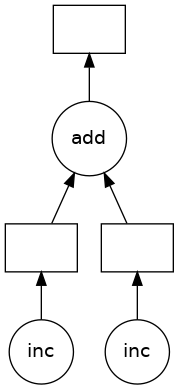

In [61]:
z.visualize() # make sure you have graphviz installed

We can see that add needs to wait for the two evaluations of the inc function. Let's compute the actual value of z and time it.

In [62]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 155 ms, sys: 44.8 ms, total: 199 ms
Wall time: 2.02 s


5

## For loop

Let's say we have the following data vector and we want to sum the evaluation of the inc function over these values:

In [63]:
data = range(20)

In [64]:
list(data)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Let's evaluate and sum sequentially

In [65]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)
print(total)

210
CPU times: user 1.54 s, sys: 312 ms, total: 1.85 s
Wall time: 20 s


Let's do this using delayed

In [66]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('sum-6a82c1d1-0648-4ddf-adb8-099ff21ca2ce')
After computing : 210
CPU times: user 264 ms, sys: 43.3 ms, total: 307 ms
Wall time: 3.04 s


It only took 3 seconds! Let's look at the graph:

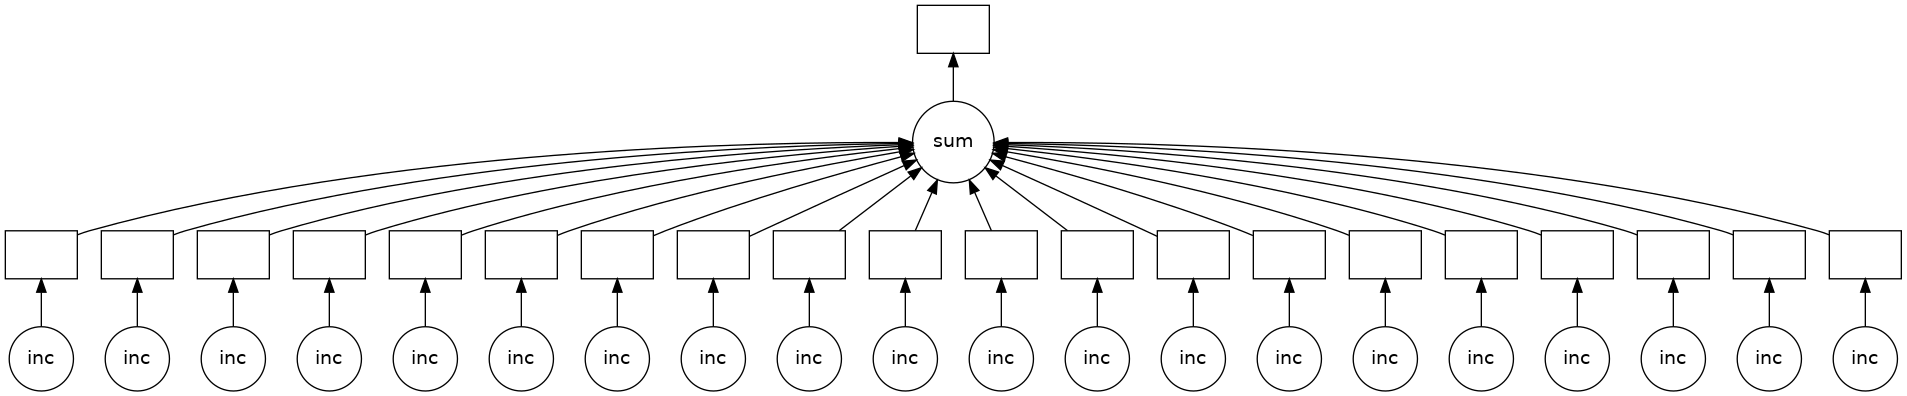

In [67]:
total.visualize()

What about using numpy arrays?

In [68]:
%%time
np.sum(inc(np.array(data)))

CPU times: user 71.2 ms, sys: 21.1 ms, total: 92.2 ms
Wall time: 1 s


210

In this case it was even faster, just one second, the minimum possible! One should always try using numpy first, but if the function is very complex it may be better to use Dask delayed.

## Bottle neck

Let's now consider the case where many computations need to happen before a bottle neck, which then triggers more expensive functions:

In [69]:
def mult2(y0, y1):
    # use 100% CPU for some seconds                                                                                                                                                                  
    y = y0
    for i in range(100000000):
        y = y * y0
    return y * y1

In [70]:
%%time
results = []
for i in range(4):
    results.append(mult2(1 + 1e-10, 1))
aux = sum(results)
results = []
for i in range(4):
    results.append(mult2(1 + 1e-10, aux))
total = sum(results)
print(total)

16.323221470685194
CPU times: user 30.3 s, sys: 338 ms, total: 30.6 s
Wall time: 30.3 s


In [78]:
%%time
results = []
for i in range(4):
    results.append(delayed(mult2)(1 + 1e-10, 1))
aux = delayed(sum)(results)
results = []
for i in range(4):
    results.append(delayed(mult2)(1 + 1e-10, aux))
total = delayed(sum)(results)
print(total)

Delayed('sum-1e739196-c347-424e-a4c5-be4cfd705f9d')
CPU times: user 2.47 ms, sys: 0 ns, total: 2.47 ms
Wall time: 1.84 ms


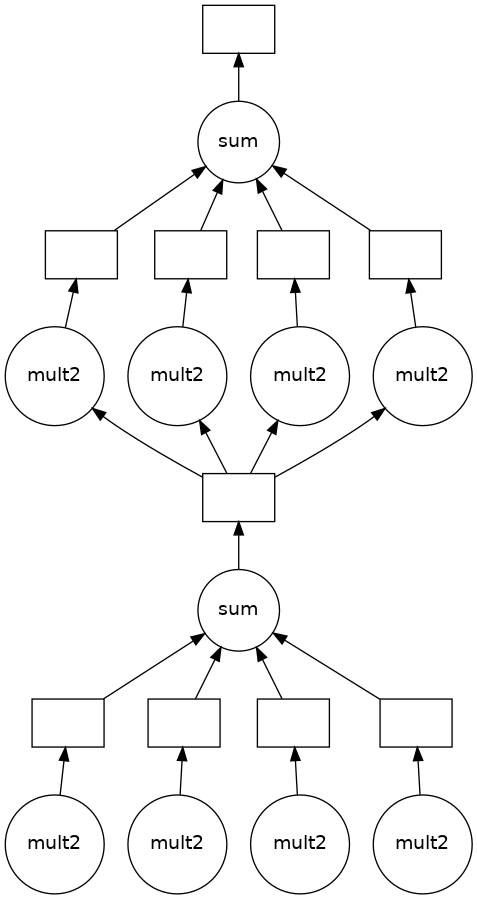

In [79]:
total.visualize()

In [73]:
%%time
total.compute()

CPU times: user 1.17 s, sys: 229 ms, total: 1.4 s
Wall time: 13.9 s


16.323221470685194

Note that this didn't take 1/4th of the time.

Let's try a different way of writing the same:

In [80]:
%%time
total = 0
for i in range(4):
    total += delayed(mult2)(1 + 1e-10, 1)
aux = total
total = 0
for i in range(4):
    total += delayed(mult2)(1 + 1e-10, aux)
print(total)

Delayed('add-68e1d99cddc731610fca7ef6461db66f')
CPU times: user 3.28 ms, sys: 0 ns, total: 3.28 ms
Wall time: 2.47 ms


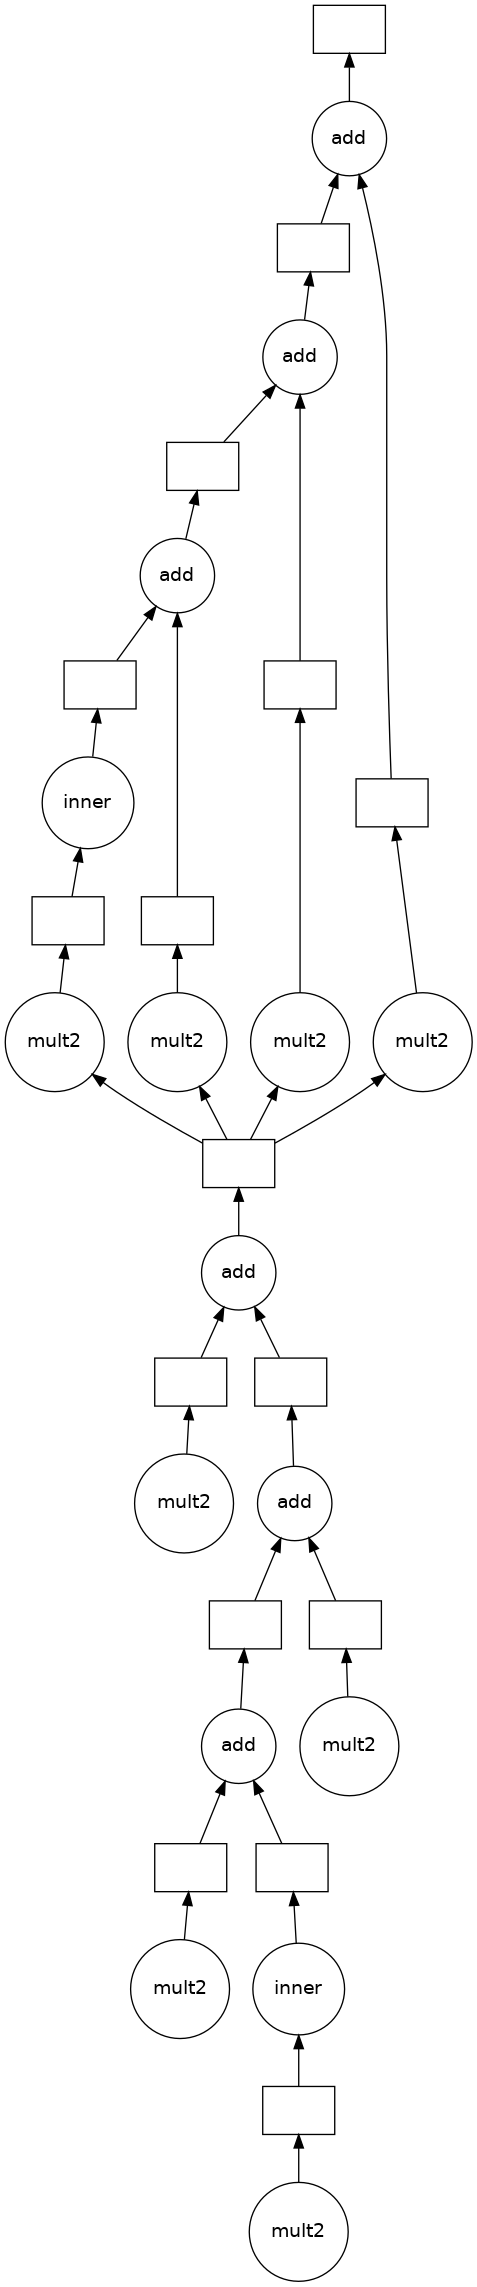

In [81]:
total.visualize()

In [34]:
%%time
total.compute()

CPU times: user 562 ms, sys: 91.9 ms, total: 654 ms
Wall time: 13.2 s


16.323221470685194

## For loop with flow control

Let's consider the case where we have conditions on the data. We will either increment the value by one or double the value depending on whether the value is even or odd.

In [35]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

Let's do a sequential call

In [82]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)

total = sum(results)
print(total)

290
CPU times: user 1.44 s, sys: 318 ms, total: 1.76 s
Wall time: 20 s


Now do a delayed call:

In [84]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = delayed(double)(x)
    else:
        y = delayed(inc)(x)
    results.append(y)

total = delayed(sum)(results)
print(total)

Delayed('sum-b09873a7-61b7-4847-a5bb-176d4a24d569')
CPU times: user 3.46 ms, sys: 0 ns, total: 3.46 ms
Wall time: 2.83 ms


And we visualize it.

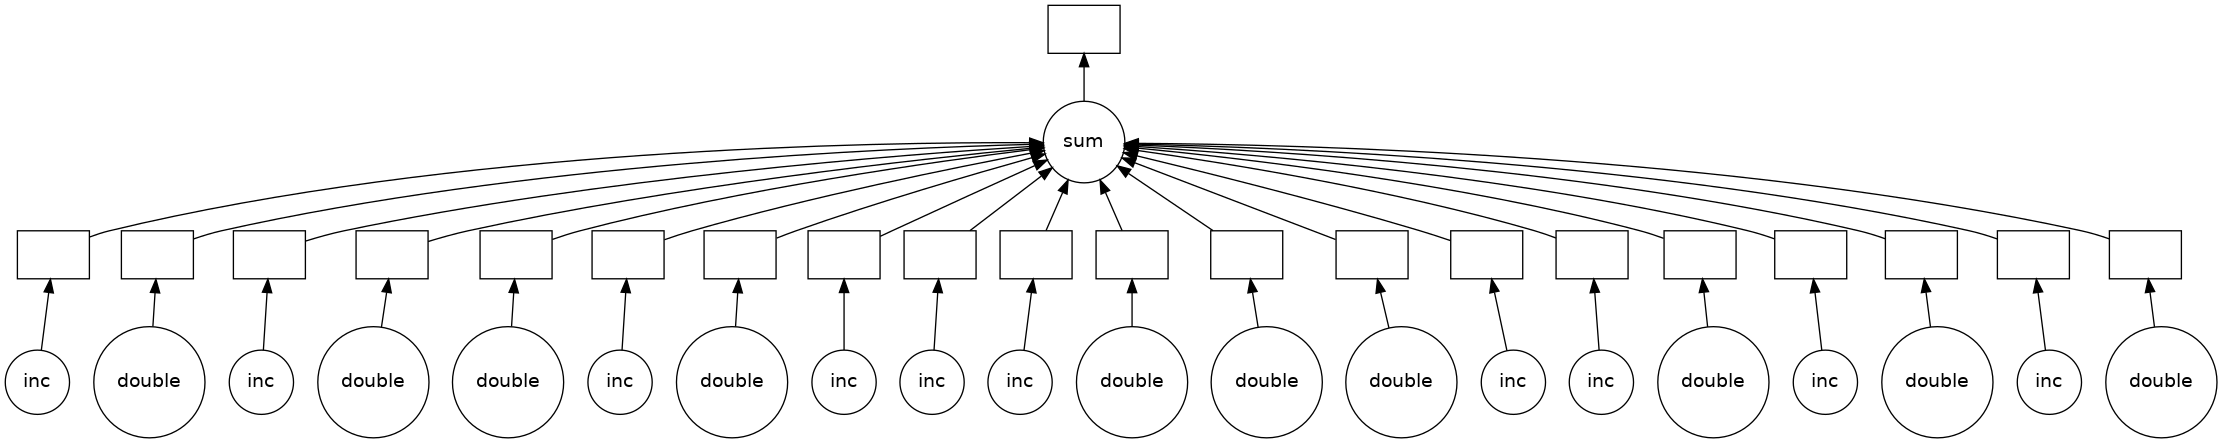

In [85]:
total.visualize()

Note that the visualization is not necessarilly ordered in the same way the data variable is ordered. Also note that we cannot build a delalyed version of `is_even`.

Let's now compute the value.

In [86]:
%%time
total.compute()

CPU times: user 267 ms, sys: 50.7 ms, total: 317 ms
Wall time: 3.04 s


290

It took only 3 seconds.

## Working with pandas

We will use data from here http://ww2.amstat.org/sections/graphics/datasets/DataExpo2009.zip.

These are flight path delays. Make sure to create a `data` directory before running this.

In [42]:
%run prep.py -d flights

- Downloading NYC Flights dataset... done
- Extracting flight data... done
- Creating json data... done
** Created flights dataset! in 5.01s**


Let's look at the files

In [87]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

Let's read one file with pandas and display it

In [88]:
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


The column `DepDelay` contains the departure delays and the column `Origin` contains the airport origins.

In [89]:
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

Let's find files recursively with glob

In [90]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [91]:
filenames

['data/nycflights/1990.csv',
 'data/nycflights/1991.csv',
 'data/nycflights/1992.csv',
 'data/nycflights/1993.csv',
 'data/nycflights/1994.csv',
 'data/nycflights/1995.csv',
 'data/nycflights/1996.csv',
 'data/nycflights/1997.csv',
 'data/nycflights/1998.csv',
 'data/nycflights/1999.csv']

Let's compute the mean departure delay sequentially:

In [92]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 3.94 s, sys: 104 ms, total: 4.05 s
Wall time: 3.74 s


In [93]:
print(mean)

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64


Let's run a parallelized version of the above

In [94]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = delayed(sum)(sums)
n_flights = delayed(sum)(counts)
mean = total_delays / n_flights

CPU times: user 11.2 ms, sys: 531 µs, total: 11.7 ms
Wall time: 10.6 ms


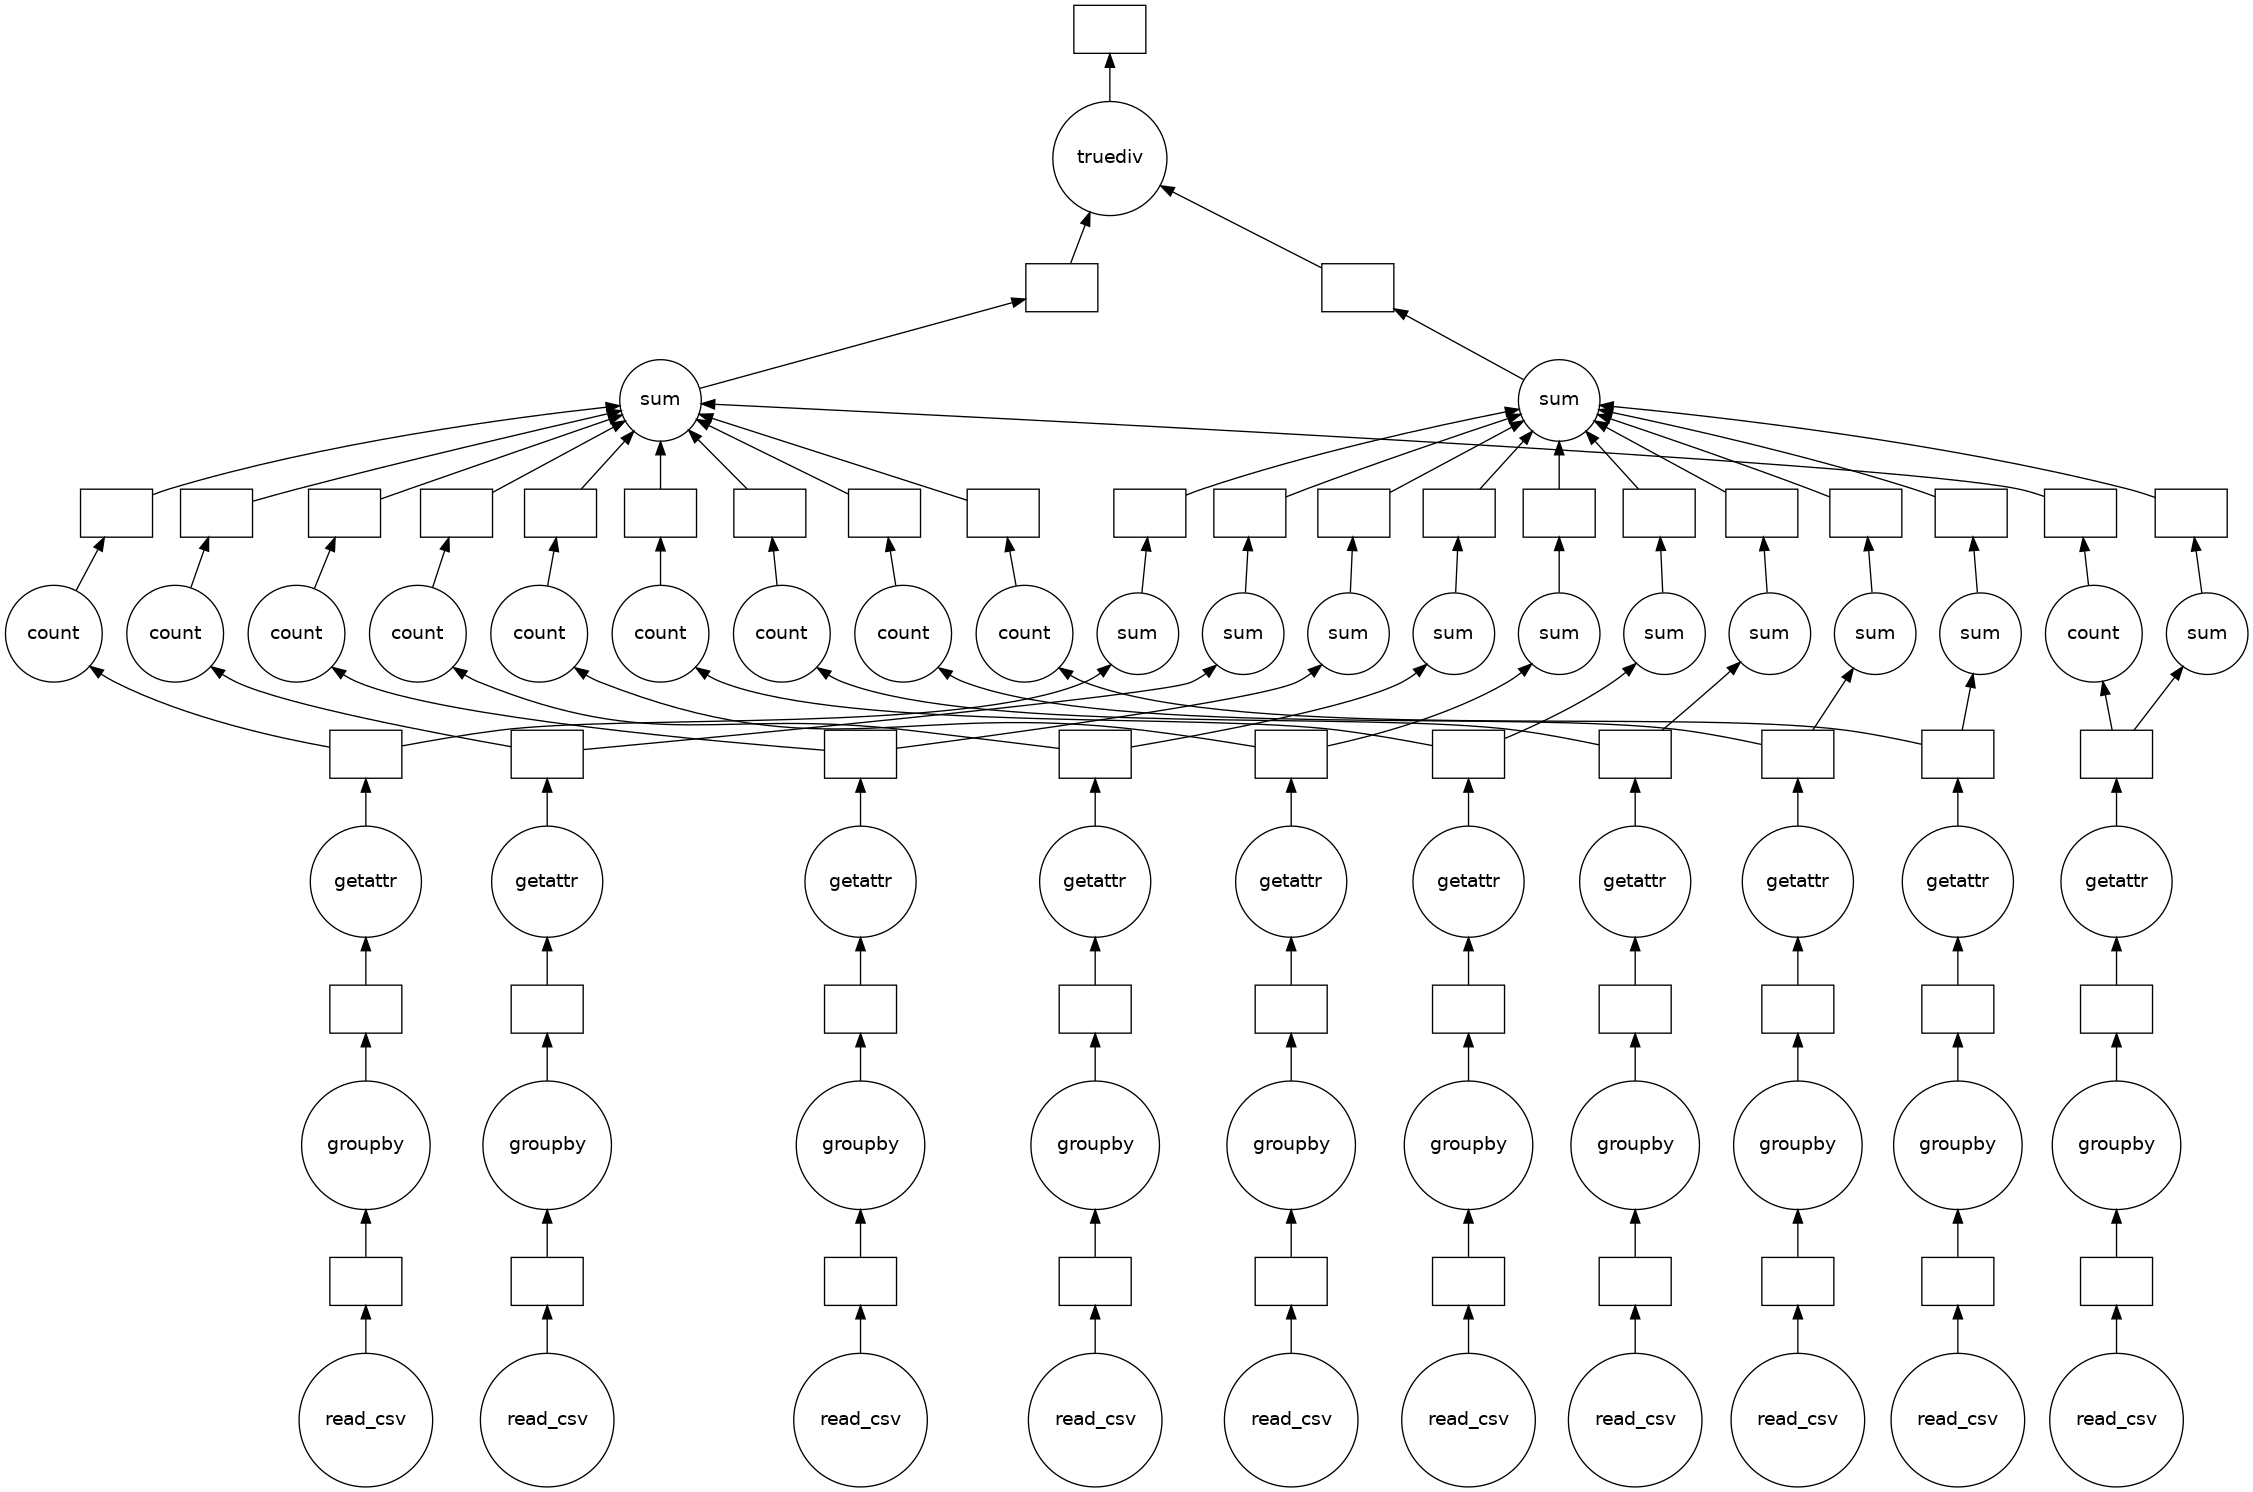

In [95]:
mean.visualize()

In [96]:
%%time
mean.compute()

CPU times: user 244 ms, sys: 28.8 ms, total: 273 ms
Wall time: 1.61 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

Finally, stop the client

In [58]:
client.close()